# By:
# Flora Vyas |
# Daragh Haughton | 25237943

# Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq

import re

# Functions

In [25]:
def analyze_panel(df_panel, panel_name):
  '''
  Function that analyzes solar panel voltage data and produces the angular rotation rate

  Parameters:
  df_panel : dtype = DataFrame
    A dataFrame containing the solar panel measurements with columns:
    - 'time_sec': time in seconds
    - 'voltage': voltage measurements in volts
  panel_name : dtype = str
    Name of the panel (e.g., '+X', '-Y') for labeling plots and print statements

  Returns:
  dominant_freq : dtype = float
    Dominant frequency from FFT in Hz
  angular_rate : dtype = float
    Angular rotation rate in rad/s
  time : dtype = array
    array of time entries
  volt : dtype = array
    array of voltage entries
  freqs : dtype = array
    array of frequency values returned
  powerr : dtype = array
    array of power values returned
  '''
  # extract data from the panel dataframe
  time = df_panel["time_sec"].values
  volt = df_panel["voltage"].values

  # detrend the voltage
  vdetrend = volt - np.mean(volt)

  N = len(time)
  dt = np.mean(np.diff(time))

  # perform FFT, calculate power spectrum
  freqs = fftfreq(N, dt)
  fft_values = fft(vdetrend)
  power = np.abs(fft_values)**2

  # ensuring only positive frequencies retained
  posis = freqs > 0
  freqss = freqs[posis]
  powerr = power[posis]

  # find the dominant frequency and angular rate
  domfreq = freqss[np.argmax(powerr)]
  angrate = 2 * np.pi * domfreq

  return domfreq, angrate, time, volt, freqss, powerr


def load_panel_voltages(filename):
  '''
  Function reads in solar panel data from .txt files for degraded and non-degraded solar panels

  Parameters
    filename : str
      Path to text file containing solar panel data.
      Expected format: timestamp, panel, voltage, current
      where panel either '+X', '+Y', or '+Z' (always 'Y')

  Returns
    panel_data : dtype = dict
      A dictionary containing the data from the text file for each panel
  '''
  panel_data = {'+X': [],
                '+Y': [],
                '+Z': []}

  with open(filename, 'r') as f:
    for line in f:
      values = line.strip().split(',')
      # ensuring that the data file has the expected size
      if len(values) != 4:
        print('Might want to check that')
        continue

      # separating the parts
      timestamp, panel, voltage, current = values
      voltage = float(voltage)

      if panel in panel_data:
        panel_data[panel].append(voltage)

  return panel_data

# Q1 - AMSAT Rotation Analysis
'Placing the AMSAT on a turntable, record the voltage produced by the solar panels as a function of time. Exporting
this data to a Jupyter notebook, determine the angular rotation rate of the AMSAT. The best way of doing this will
be through a Fourier analysis of the voltage data; scipy and
astropy contain many useful libraries for this.'

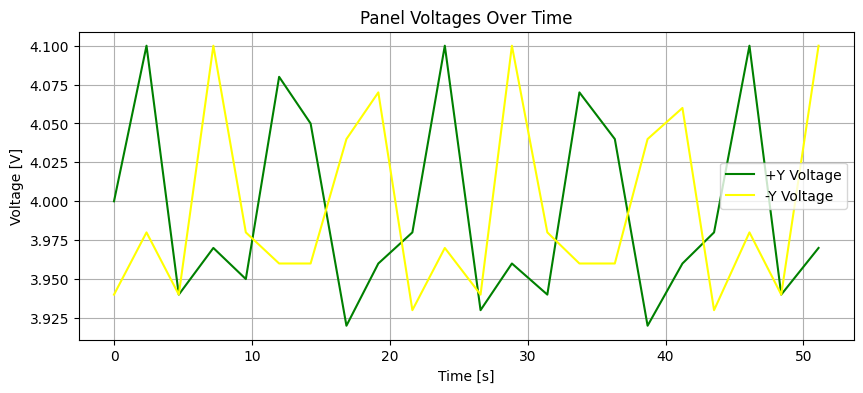

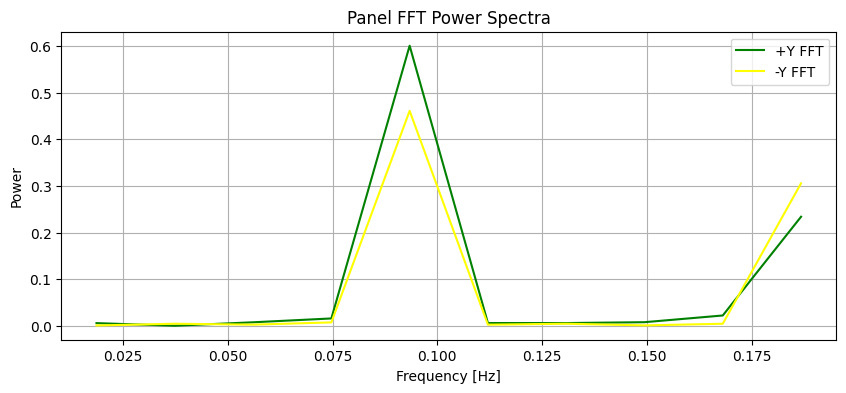

+Y:
  Dominant Frequency: 0.0934 Hz
  Angular Rate:      0.5869 rad/s
-Y:
  Dominant Frequency: 0.0934 Hz
  Angular Rate:      0.5869 rad/s


In [26]:
# read in .txt file
df = pd.read_csv("resampled.txt", names=["timestamp", "face", "voltage", "current"], parse_dates=["timestamp"],
                 dtype={"face": str, "voltage": float, "current": float}, skipinitialspace=True)

# Convert timestamp from Cubesat format into seconds
t0 = df["timestamp"].iloc[0]
df["time_sec"] = (df["timestamp"] - t0).dt.total_seconds()

panel_plot_data = {}

# panel color
panels = ["+Y", "-Y"]
panel_colors = {
    "+Y": "Green",
    "-Y": "Yellow"
}

results = {}

for panel in panels:
    df_panel = df[df["face"] == panel].copy()

    if len(df_panel) > 0:
        freq, omega, time, volt, f_pos, p_pos = analyze_panel(df_panel, panel)

        # store results
        results[panel] = {
            "frequency": freq,
            "angular_rate": omega
        }

        # store plot data
        panel_plot_data[panel] = {
            "time": time,
            "voltage": volt,
            "freqs": f_pos,
            "power": p_pos
        }

#  Plot:- Voltage vs Time

plt.figure(figsize=(10,4))
for panel in panels:
    if panel in panel_plot_data:
        data = panel_plot_data[panel]
        plt.plot(
            data["time"],
            data["voltage"],
            label=f"{panel} Voltage",
            color=panel_colors[panel]
        )

plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("Panel Voltages Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot:- FFT Power Spectra

plt.figure(figsize=(10,4))
for panel in panels:
    if panel in panel_plot_data:
        data = panel_plot_data[panel]
        plt.plot(
            data["freqs"],
            data["power"],
            label=f"{panel} FFT",
            color=panel_colors[panel]
        )

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.title("Panel FFT Power Spectra")
plt.grid(True)
plt.legend()
plt.show()


# Print Results
for panel in panels:
    if panel in results:
        print(f"{panel}:")
        print(f"  Dominant Frequency: {results[panel]['frequency']:.4f} Hz")
        print(f"  Angular Rate:      {results[panel]['angular_rate']:.4f} rad/s")

# Q2 - AMSAT Gyro analysis
'Determine the angular acceleration using the onboard accelerometer. How does this compare to what you indirectly
infer from the solar panel voltages, and what can you say
about the accuracy of the two methods, and the tolerance of
the turntables?'

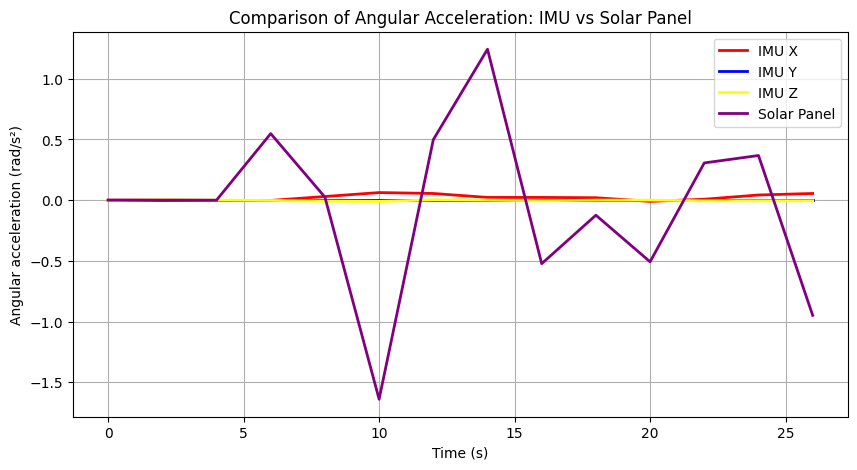

The X axis Gyroscope values: [4.88692191 4.88692191 4.88692191 4.88692191 4.88692191 4.88692191
 4.88692191 4.88692191 4.88692191 4.88692191 4.88692191 4.88692191
 4.88692191 4.88692191]

The Y axis Gyroscope values: [0.39304815 0.39304815 0.39304815 0.39287361 0.39287361 0.39496801
 0.39723694 0.39880773 0.39880773 0.40037853 0.400204   0.3996804
 0.4007276  0.40264746]

The Z axis Gyroscope values: [17.70845966 17.70828512 17.70863419 17.70828512 17.70845966 17.70776152
 17.70776152 17.70793606 17.70776152 17.70758699 17.70776152 17.70758699
 17.70741246 17.70723793]


In [34]:
filename = 'AccvsTime.txt'

ax_list, ay_list, az_list = [], [], []
gx_list, gy_list, gz_list = [], [], []
panel_angle_list = []
time_list = []

t = 0
dt = 2

with open(filename, "r") as f:
  for line in f:
    # extracting the data from the MPU6050 sensor
    if "MPU6050" in line:
      # GenAI was used here. Specifically, ChatGPT-4-Turbo was used for assistance in using regex.
      # Specifically, GenAI provided the syntax needed to use regex
      nums = re.findall(r"[-+]?\d*\.\d+|\d+", line)

      gx = float(nums[0])
      gy = float(nums[1])
      gz = float(nums[2])

      ax = float(nums[3])
      ay = float(nums[4])
      az = float(nums[5])

      xs = float(nums[6])

      ax_list.append(ax)
      ay_list.append(ay)
      az_list.append(az)

      gx_list.append(gx)
      gy_list.append(gy)
      gz_list.append(gz)

      panel_angle_list.append(xs)

      time_list.append(t)
      t += dt

t = np.array(time_list)
ax = np.array(ax_list)
ay = np.array(ay_list)
az = np.array(az_list)
gx = np.array(gx_list)
gy = np.array(gy_list)
gz = np.array(gz_list)

panel = np.array(panel_angle_list)

# Gyro is in milli deg/s, so must convert to rad/s
gyro_x = gx * np.pi/180
gyro_y = gy * np.pi/180
gyro_z = gz * np.pi/180

# gradient of voltage
# GenAI was used here, specifically ChatGPT-4-Turbo.
# Specifically, GenAI provided the line seen below, in order to
# calculate angular acceleration from the angular velocity data

# While it was known a derivative would be needed to get from velocity to acceleration,
# we struggled with finding a specific method to suit our needs. GenAI suggested using np.gradient.
# This GenAI solution was also used below.

alpha_imu_x = np.gradient(gy, t)
alpha_imu_y = np.gradient(gx, t)
alpha_imu_z = np.gradient(gz, t)

#converting panel angles to radians
panel_rad = panel * np.pi/180

omega_panel = np.gradient(panel_rad, t)
alpha_panel = np.gradient(omega_panel, t)

plt.figure(figsize=(10,5))
plt.plot(t, alpha_imu_x, label="IMU X", linewidth=2, color="red")
plt.plot(t, alpha_imu_y, label="IMU Y", linewidth=2, color="blue")
plt.plot(t, alpha_imu_z, label="IMU Z", linewidth=2, color="yellow")
plt.plot(t, alpha_panel, label="Solar Panel", linewidth=2, color="purple")
plt.xlabel("Time (s)")
plt.ylabel("Angular acceleration (rad/s²)")
plt.legend()
plt.grid()
plt.title("Comparison of Angular Acceleration: IMU vs Solar Panel")
plt.show()

print(f'The X axis Gyroscope values: {gyro_x}')
print()
print(f'The Y axis Gyroscope values: {gyro_y}')
print()
print(f'The Z axis Gyroscope values: {gyro_z}')

Interpretation of these results

These results are evidently poor, with the gyroscope values returned being significantly smaller than those produced by the solar panel. While this would be expected for 2 axis of gyration (the subesat was shaken roughly in 1 direction only), the fact that all axis' exhibit similarly low values supports some sort pf systematic error in the collection, handling or visualisation of the data.

# Q3 - Panel degradation analysis

How does the degradation of solar panels affect the output voltage? You can explore this by covering part of the
panels with paper and tape (do not apply tape directly to
the panel surface) or alternatively by carefully coating one
of the panels with chalk dust. How does the voltage and
current change with fraction of the panel that is available?

+Y panel:
  Uncovered mean V: 1.010 V
  Partial covered mean V  : 1.028 V
  Covered mean V  : 0.721 V
  Full voltage drop   : 28.6%

  Partial voltage drop   : -1.8%



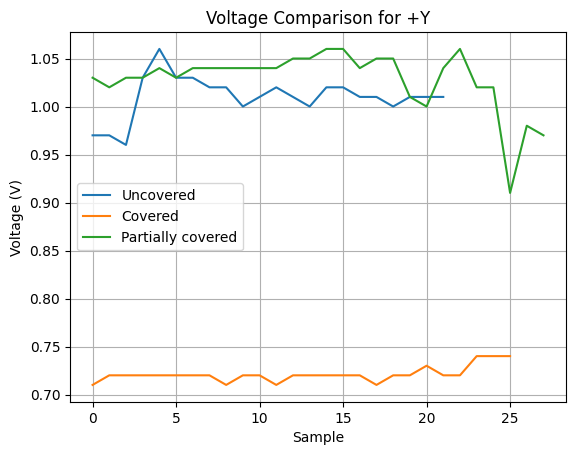

In [28]:
uncovered = load_panel_voltages("panelnodegradation.txt")
covered   = load_panel_voltages("panelfulldegradation.txt")
partialcover = load_panel_voltages("panelhalfdegradation.txt")

# Compare mean voltages between uncovered and covered panel
for panel in ['+Y']:
  Vu = np.mean(uncovered[panel])
  Vc = np.mean(covered[panel])
  Vp = np.mean(partialcover[panel])

  print(f"{panel} panel:")
  print(f"  Uncovered mean V: {Vu:.3f} V")
  print(f"  Partial covered mean V  : {Vp:.3f} V")
  print(f"  Covered mean V  : {Vc:.3f} V")

  dropf = ((Vu - Vc) / Vu) * 100
  print(f"  Full voltage drop   : {dropf:.1f}%\n")

  dropp = ((Vu - Vp) / Vu) * 100
  print(f"  Partial voltage drop   : {dropp:.1f}%\n")

plt.plot(uncovered[panel], label="Uncovered")
plt.plot(covered[panel], label="Covered")
plt.plot(partialcover[panel], label="Partially covered")

plt.title(f"Voltage Comparison for +Y")
plt.xlabel("Sample")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid()
plt.show()


Interpretation of above results
These results somewhat make sense. The covered panel produces the lowest voltage, and the uncovered produces much higher voltage. The difference is not huge, likely due to how the panel was covered with white paper, which may have let some light through. What DOESN'T make any sense is how the partially covered panel somehow has higher voltage than the uncovered one.

It is likely due to the experimental set up. The lamp was placed at the same difference everytime from the cubesat, but the angle could not be fixed much, leading the light to shine down behind the cover somewhat. This explains why the voltages are somewhat similar, but the fact they are so close and that the partially covered panel has higher voltage is incorrect.

# Q4 - Difference in Query times depending on whether in Ground station or Onboard satellite

When you query a sensor over ssh (perhaps through a
Jupyter notebook) it will take a finite time to execute. What
is the delay introduced by the groundstation (i.e. your computer), compared to on-board processing? Is this constant,
or does this change if the AMSAT is trying to do several
things at once? You can explore this with the time command either from the terminal or through Python

In [29]:
onboard = []
gs = []

filename = 'AMSAT RELAY DATA.txt'
with open(filename, "r") as f:
 curr = None

 for line in f:
  line = line.strip()

  if line == 'Onboard':
    curr = 'onboard'
  elif line == 'Groundstation':
    curr = 'groundstation'
  elif line:
    value = line
    value = float(value)

    if curr == 'onboard':
      onboard.append(value)
    elif curr == 'groundstation':
      gs.append(value)

onboard = np.array(onboard)
gs = np.array(gs)

print(f'Onboard mean: {np.mean(onboard):.3f} s')
print(f'Onboard std : {np.std(onboard):.3f}s')

print(f'Groundstation mean: {np.mean(gs):.3f} s')
print(f'Groundstation std : {np.std(gs):.3f} s')

print(f'Extra overhead: {(np.mean(gs) - np.mean(onboard)):.3f} s')

Onboard mean: 0.431 s
Onboard std : 0.013s
Groundstation mean: 11.576 s
Groundstation std : 1.054 s
Extra overhead: 11.145 s


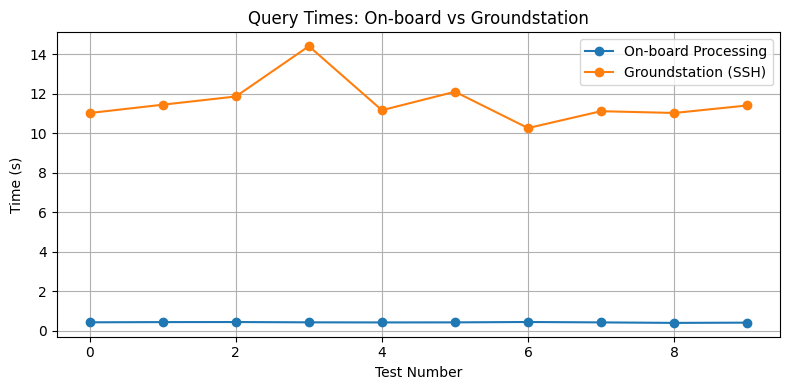

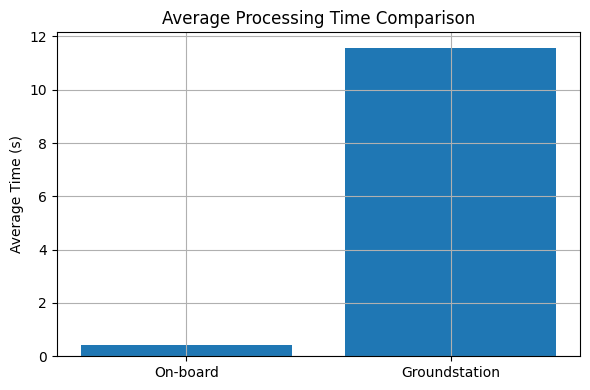

In [30]:
plt.figure(figsize=(8,4))
plt.plot(onboard, marker='o', label="On-board Processing")
plt.plot(gs, marker='o', label="Groundstation (SSH)")
plt.xlabel("Test Number")
plt.ylabel("Time (s)")
plt.title("Query Times: On-board vs Groundstation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

avg_onboard = np.mean(onboard)
avg_ground = np.mean(gs)

plt.figure(figsize=(6,4))
plt.bar(["On-board", "Groundstation"], [avg_onboard, avg_ground])
plt.grid(True)
plt.ylabel("Average Time (s)")
plt.title("Average Processing Time Comparison")
plt.tight_layout()
plt.show()

Interpretation of results

The processing task was for the ssh protocol to print 'hello', and was done both on the cubesat terminal and within a separate ssh terminal.

As expected, onboard processing is much faster than ground station processing, and also has much less variation, with onboard processing producing very similar times over each run

In [31]:
telem = []
notelem = []

filename = 'AMSAT RELAY DATA TELEM.txt'
with open(filename, "r") as f:
 curr = None

 for line in f:
  line = line.strip()

  if line == 'telem without':
    curr = 'notelem'
  elif line == 'telem with':
    curr = 'telem'
  elif line:
    value = line
    value = float(value)

    if curr == 'notelem':
      notelem.append(value)
    elif curr == 'telem':
      telem.append(value)

telem = np.array(telem)
notelem = np.array(notelem)

print(f'Telem mean time with cubesatsim: {np.mean(telem):.3f} s')
print(f'Telem std with cubesatsim: {np.std(telem):.3f} s')

print(f'Telem mean time without cubesatsim: {np.mean(notelem):.3f} s')
print(f'Telem std without cubesatsim: {np.std(notelem):.3f} s')

print(f'Extra overhead: {(np.mean(notelem) - np.mean(telem)):.3f} s')

Telem mean time with cubesatsim: 0.033 s
Telem std with cubesatsim: 0.007 s
Telem mean time without cubesatsim: 0.014 s
Telem std without cubesatsim: 0.001 s
Extra overhead: -0.019 s


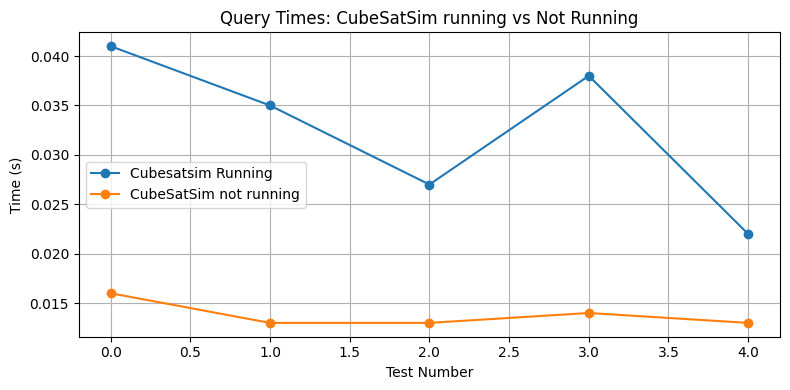

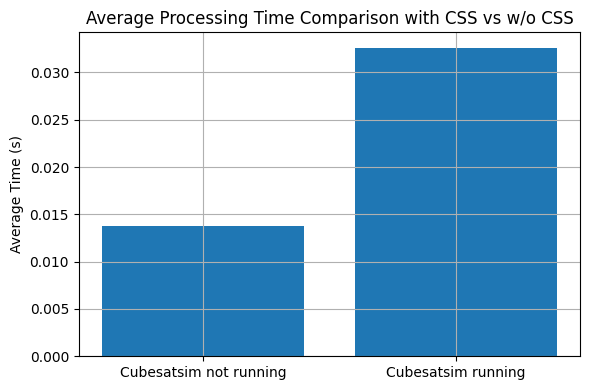

In [32]:
plt.figure(figsize=(8,4))
plt.plot(telem, marker='o', label="Cubesatsim Running")
plt.plot(notelem, marker='o', label="CubeSatSim not running")
plt.xlabel("Test Number")
plt.ylabel("Time (s)")
plt.title("Query Times: CubeSatSim running vs Not Running")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

avgtelem = np.mean(telem)
avgnotelem = np.mean(notelem)

plt.figure(figsize=(6,4))
plt.bar(["Cubesatsim not running", "Cubesatsim running"], [avgnotelem, avgtelem])
plt.grid(True)
plt.ylabel("Average Time (s)")
plt.title("Average Processing Time Comparison with CSS vs w/o CSS")
plt.tight_layout()
plt.show()

Interpretation of these results
- For this section, cubesatsim was run, and while running, telem was run and the time taken for the output to show was recorded.

- As expected, when CubeSatSim was running, the time taken for the query to be completed was much higher. When cubesatsim was not running, the query time was extremely low.

# Some pictures from the CubeSat labs

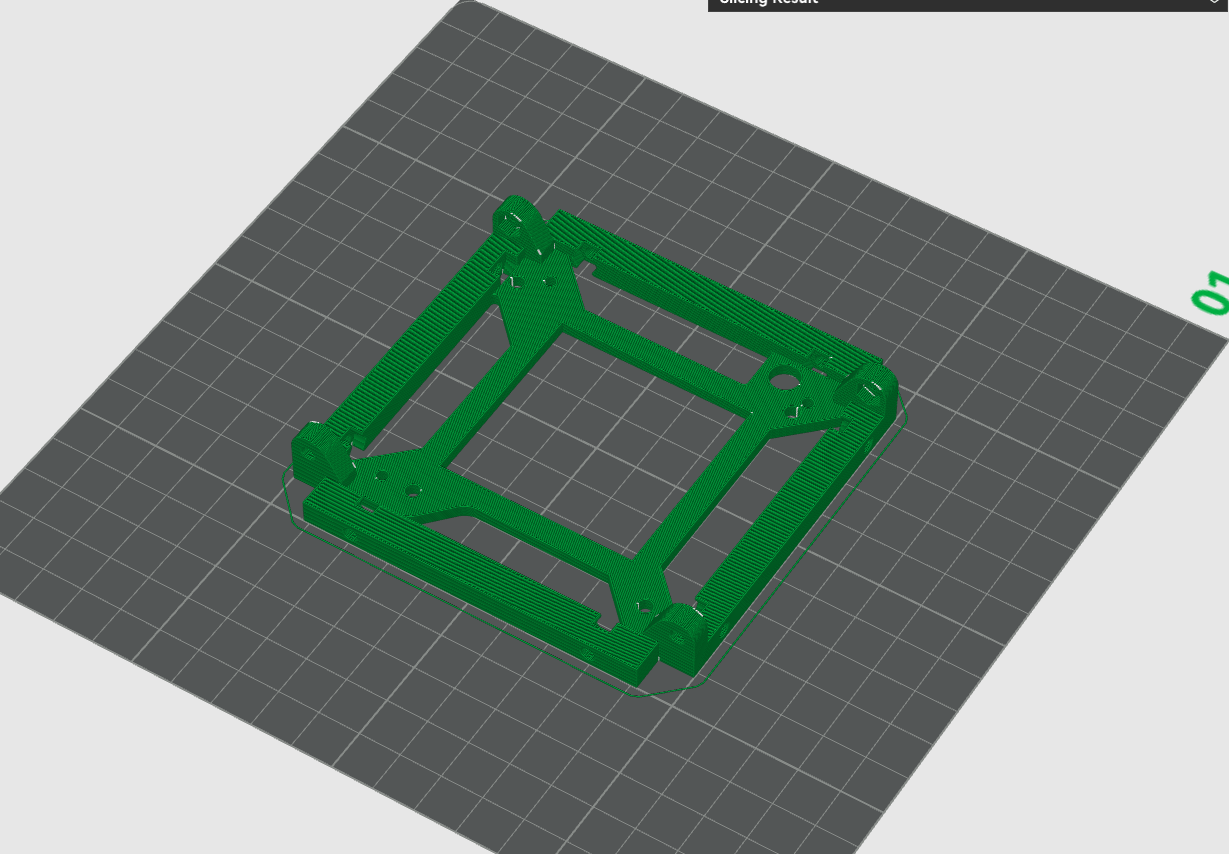

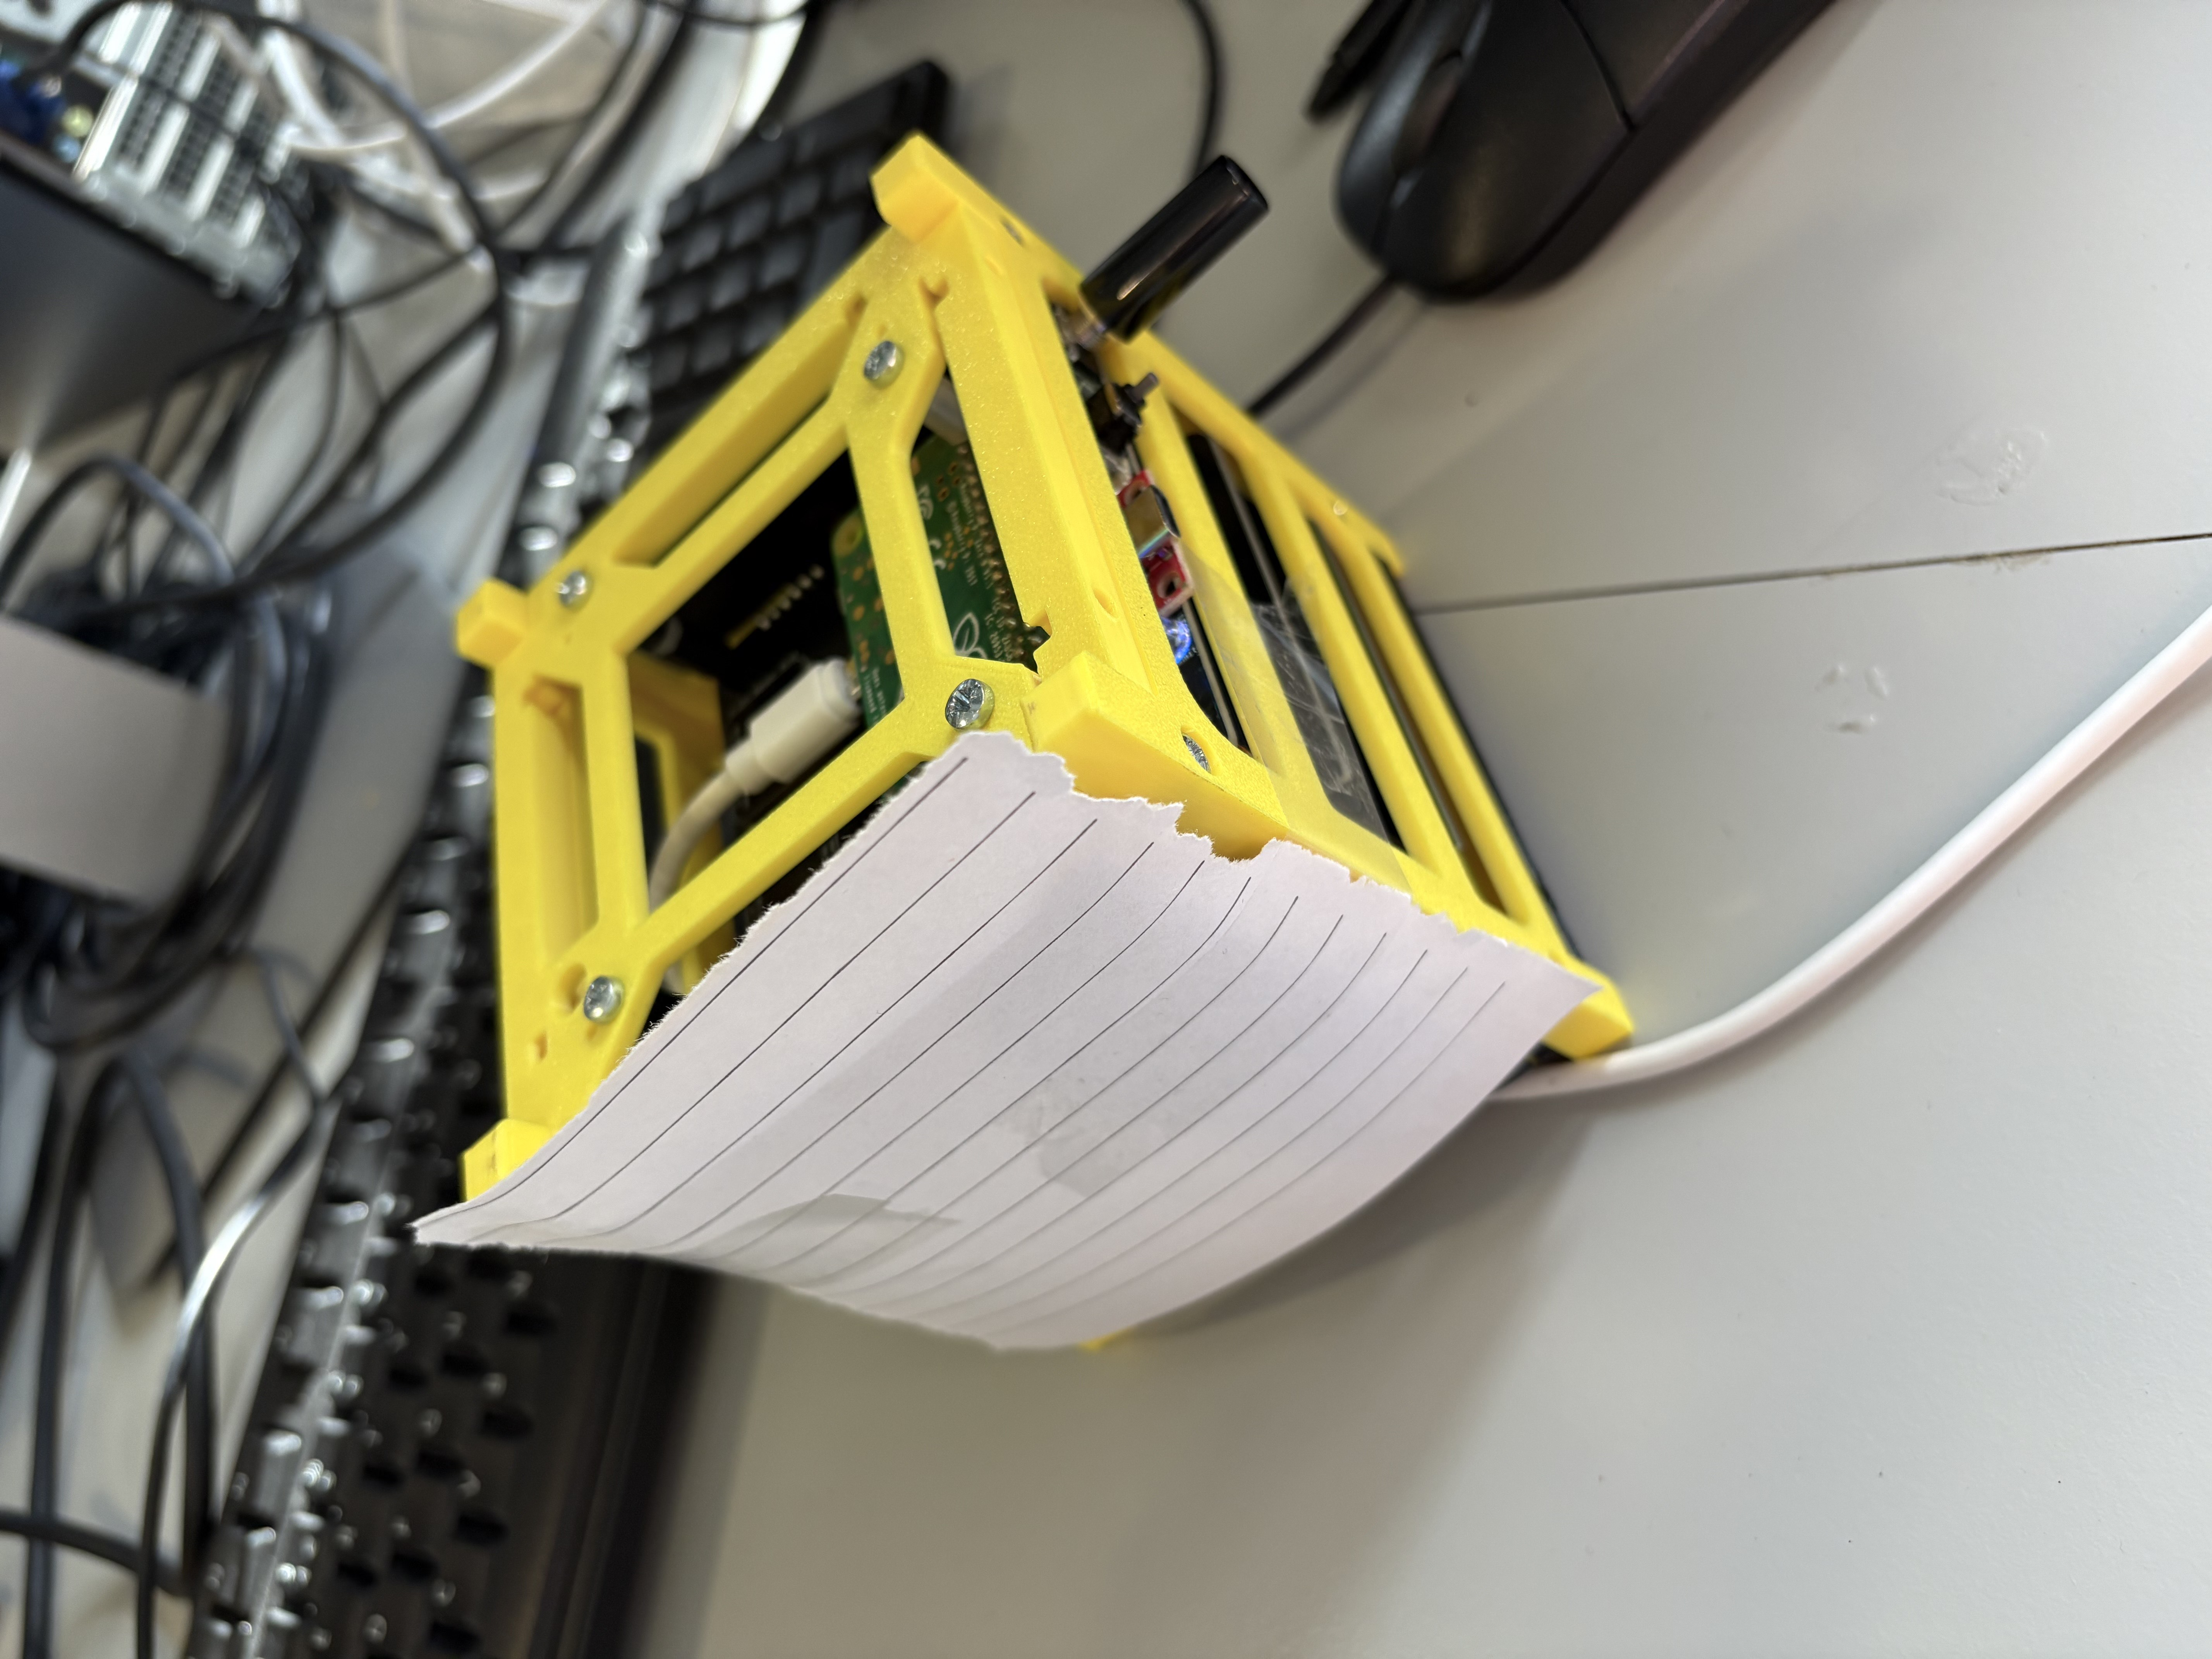

# Introductory Exercises from amsat introduction notebook

**Exercise 1

 Open a command-line terminal and connect to your AMSAT over ssh as discussed in the manual, and navigate to the CubeSatSim directory. There are two files we are interested in: telem, and cubesatsim. In the terminal, run the telem binary and copy and paste the output into the cell below, and provide a brief comment on the output.**

Answer:
Sample telem output:

- 2025-11-11T12:31:28.294539 +X 0.0 0.0
- 2025-11-11T12:31:28.294539 +Y 4.09 36.0
- 2025-11-11T12:31:28.294539 +Z 0.0 0.0

__________________________________________

**Exercise 2**

- **1: Redirect both output streams from telem to appropriately named files (e.g. telem_stdout.txt and telem_stderr.txt. Comment in the cell below on how telem communicates its information. Use the sftp command to copy these files to your working directory on the lab computer.**

- - Answer 1: telem communicates by writing solar panel data (battery and bus voltage/current information) to standard output (stdout). Any error messages or diagnostic information are sent to standard error (stderr). When run, it executes once, retrieves the current telemetry snapshot from the CubeSat, and outputs the data before it automatically terminates.

- **2: Repeat Part 1 for the cubesatsim binary, and comment in the cell below on how the binary communicates its information.**

- - Answer 2: The cubesatsim binary communicates by continuously streaming telemetry data to standard output (stdout), giving real-time, current solar panel voltage and current measurements for the battery and bus. Unlike telem which gives a snapshot of these, cubesatsim runs as a persistent process, outputting updated measurements at regular intervals until terminated. Any errors or status messages are sent to standard error (stderr).